In [1]:
import pandas as pd

train_df = pd.read_csv('train.En.csv')

train_df.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [2]:
train_df['sarcastic'].value_counts()

0    2601
1     867
Name: sarcastic, dtype: int64

In [3]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip #shows the different embeddings downloaded from glove, using 50 dimensional word embeddings for this project

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 40s  

2024-03-27 00:13:22 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
#creating a dictionary and adding the glove embeddings
import numpy as np
words = dict()

def add_to_dict(d, filename):
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')

            try:
                d[line[0]] = np.array(line[1:], dtype=float) # separates word [line[0]] from its embeddings [line[1:]]
            except:
                continue
add_to_dict(words, 'glove.6B.50d.txt')

In [5]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 9.6 MB/s eta 0:00:00


In [6]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import emoji
nltk.download('wordnet') # for nlp tasks
#Preporcess, tokenize and create embeddings
# Load the NLTK tokenizer
tokenizer =  TweetTokenizer()  #nltk.RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()

# Define URL, hashtag, and mention regex patterns
url_regex = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
hashtag_regex = re.compile(r'#\S+')
mention_regex = re.compile(r'@\w+')

def preprocess_type_II(tweet_text):
    if pd.isna(tweet_text) or tweet_text == '':
        return tweet_text

    # Convert urls to HTTPURL, user handles to @USER token, delete hashtags
    tweet_text = url_regex.sub('HTTPURL', tweet_text)
    tweet_text = mention_regex.sub('@USER', tweet_text)
    tweet_text = hashtag_regex.sub('', tweet_text)

    return tweet_text

def preprocess_type_III(tweet_text):
    if pd.isna(tweet_text) or tweet_text == '':
        return tweet_text

    # Use function to convert urls to HTTPURL, user handles to @USER token, delete hashtags
    tweet_text = preprocess_type_II(tweet_text)

    # Replace contractions with full forms
    contraction_mapping = {"isn't": "is not", "’cause": "because", "You'd": "you would", "I’m": "I am",
                           "Couldn't": "Could not", }  # Customize as needed
    for contraction, full_form in contraction_mapping.items():
        tweet_text = tweet_text.replace(contraction, full_form)

    # Convert emotion icons to their string text
    tweet_text = emoji.demojize(tweet_text)

    return tweet_text


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
def message_to_token_list(s, preprocess_func=preprocess_type_III):
    # Apply preprocessing
    s = preprocess_func(s)
    s = str(s)
    s = s.replace("&amp;", "&")  # Replace HTML

    # Tokenize the preprocessed text
    tokens = tokenizer.tokenize(s)
    lowercased_tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
    useful_tokens = [t for t in lemmatized_tokens if t in words]

    return useful_tokens

In [8]:
def message_to_word_vectors(message, word_dict=words):

    processed_list_of_tokens = message_to_token_list(message) #preprocessing and tokenization step

    vectors = [] # initialize empty array

    for token in processed_list_of_tokens:

        if token not in word_dict: #word embedding dictionary
            continue

        token_vector = word_dict[token] #whatever word we saw there get its corresponding vector
        vectors.append(token_vector)


    return np.array(vectors, dtype=float)

In [9]:
#splitting the training data into train, validation and test dataframes
train_df = train_df.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(2427, 520, 521)

In [10]:
#x inputs and y is outputs
def df_to_X_y(dff):
    y = dff['sarcastic'].to_numpy().astype(int)
    
    all_word_vector_sequences = []#inputs
    
    for message in dff['tweet']:
        message_as_vector_seq = message_to_word_vectors(message)
        
        if message_as_vector_seq.shape[0] == 0:
            message_as_vector_seq = np.zeros(shape=(1, 50))
            
        all_word_vector_sequences.append(message_as_vector_seq) # diff num of tokens in each message

    return all_word_vector_sequences, y

In [11]:
X_train, y_train = df_to_X_y(train_df)

print(len(X_train), len(X_train[1])) #highlights different sequences length

2427 32


count    2427.000000
mean       20.196951
std        12.493030
min         1.000000
25%        11.000000
50%        18.000000
75%        26.000000
max        72.000000
dtype: float64

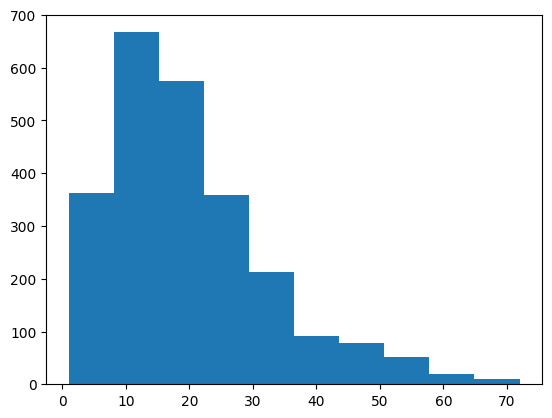

In [12]:
#data analysis-use to find the max sequence length for padding purposes

sequence_lengths = []

for i in range(len(X_train)):
    sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)
pd.Series(sequence_lengths).describe()

In [13]:
#max=72
#you look for the max tokens count to make numoy array
#we need sequence length to be the same
#make all the maximum
#zero padding
from copy import deepcopy

def pad_X(X, desired_sequence_length=73):#set to max
    X_copy = deepcopy(X)

    for i, x in enumerate(X):
        x_seq_len = x.shape[0]
        sequence_length_difference = desired_sequence_length - x_seq_len
#ading the pads # 50 is the glove
        pad = np.zeros(shape=(sequence_length_difference, 50)) #50 cause glove

        X_copy[i] = np.concatenate([x, pad]) #pad zeros at end

    return np.array(X_copy).astype(float)

In [24]:
X_train = pad_X(X_train)
X_train.shape, y_train.shape
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)
X_val.shape, y_val.shape
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)
X_test.shape, y_test.shape

((521, 73, 50), (521,))

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [26]:
import tensorflow as tf

In [27]:
model = Sequential([
    #layers.Embedding(73, 50),
    layers.Input(shape=(73, 50)),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(64, activation='relu')),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(64, activation='relu')),
    layers.Bidirectional(layers.LSTM(32)),
    #layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 73, 64)            21248     
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 73, 64)            4160      
 stributed)                                                      
                                                                 
 bidirectional_4 (Bidirecti  (None, 73, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDi  (None, 73, 64)            4160      
 stributed)                                                      
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)               

In [29]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [30]:
frequencies = pd.value_counts(train_df['sarcastic'])

frequencies

0    1823
1     604
Name: sarcastic, dtype: int64

In [31]:
#initalize weights using frequencies to help with the imbalanced dataset
#1 for non sarcastic and 4 for sarcastic- give more weight to sarcastic
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
weights

{0: 1.331321996708722, 1: 4.018211920529802}

In [32]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20
76/76 [==============================] - 56s 583ms/step - loss: 1.3869 - accuracy: 0.3890 - auc: 0.4874 - val_loss: 0.6943 - val_accuracy: 0.4192 - val_auc: 0.5067
Epoch 2/20
76/76 [==============================] - 9s 121ms/step - loss: 1.3854 - accuracy: 0.3729 - auc: 0.5214 - val_loss: 0.6972 - val_accuracy: 0.3462 - val_auc: 0.5423
Epoch 3/20
76/76 [==============================] - 13s 169ms/step - loss: 1.3839 - accuracy: 0.5332 - auc: 0.5368 - val_loss: 0.6964 - val_accuracy: 0.4000 - val_auc: 0.5513
Epoch 4/20
76/76 [==============================] - 42s 563ms/step - loss: 1.3811 - accuracy: 0.4297 - auc: 0.5580 - val_loss: 0.6723 - val_accuracy: 0.7288 - val_auc: 0.5609
Epoch 5/20
76/76 [==============================] - 10s 136ms/step - loss: 1.3773 - accuracy: 0.5402 - auc: 0.5678 - val_loss: 0.6744 - val_accuracy: 0.6750 - val_auc: 0.5617
Epoch 6/20
76/76 [==============================] - 47s 627ms/step - loss: 1.3702 - accuracy: 0.5019 - auc: 0.5915 - val_loss:

In [33]:
from tensorflow.keras.models import load_model

best_model = load_model('model/')

In [34]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report


17/17 [==============================] - 3s 40ms/step


In [ ]:
print(classification_report(y_test, test_predictions))